<a href="https://colab.research.google.com/github/MElena14/COMP341/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import random
from tqdm.notebook import tqdm
from collections import deque,namedtuple

In [26]:
import gym

# HIDE OUTPUT
!wget http://www.atarimania.com/roms/Roms.rar 
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul

--2022-04-15 12:28:00--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19583716 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar.1’

Roms.rar.1          100%[===================>]  18.68M   636KB/s    in 31s     

2022-04-15 12:28:32 (615 KB/s) - ‘Roms.rar.1’ saved [19583716/19583716]



#### Render OpenAI Gym Environments from CoLab

In [27]:
# HIDE OUTPUT
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [41]:
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

query_environment("Atlantis-ram-v0")

Action Space: Discrete(4)
Observation Space: Box(0, 255, (128,), uint8)
Max Episode Steps: 10000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


In [29]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### inital random agent

In [30]:
# HIDE OUTPUT
#env = wrap_env(gym.make("MountainCar-v0"))
env = wrap_env(gym.make("Atlantis-v0"))

observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

### Deep QN

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class DQN(nn.Module):
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        #in = 299x299
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0), #out = 149x149
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), #out = 147x147
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #out = 147x147
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0) #out = 73x73                    
        )

        self.linear = nn.Sequential(
                  nn.Linear(state_space_dim,64),
                  nn.ReLU(),
                  nn.Linear(64,64*2),
                  nn.ReLU(),
                  nn.Linear(64*2,action_space_dim)
                )
# (33600x3 and 210x64)
    def forward(self, x):
        x = x.to(device)
        print('in size=', x.size())
        x = self.block1(x)
        print('block1 size=', x.size())
        return self.linear(x)

In [33]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) 
        return random.sample(self.memory,batch_size)

    def __len__(self):
        return len(self.memory) 

### action profiles

In [34]:
def choose_action_epsilon_greedy(net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions (this list includes all the actions but the optimal one)
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly from non_optimal_actions
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [35]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out/temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    action = np.random.choice(all_possible_actions,p=softmax_out)
    
    return action, net_out.cpu().numpy()

### Define exploration profile

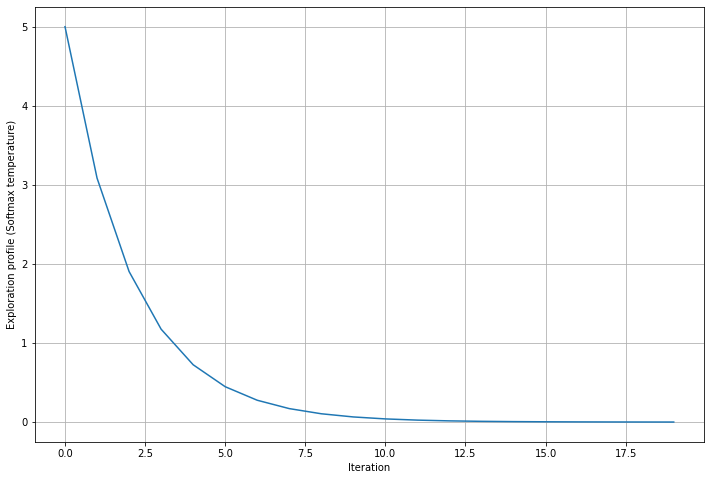

In [36]:
initial_value = 5
num_iterations = 20
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

def plotExploration(profile):
    plt.figure(figsize=(12,8))
    plt.plot(profile)
    plt.grid()
    plt.xlabel('Iteration')
    plt.ylabel('Exploration profile (Softmax temperature)')
plotExploration(exploration_profile)

### loss and optims

In [45]:

state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)

gamma = 0.99  
replay_memory_capacity = 10000   
lr = 1e-3
target_net_update_steps = 10   
batch_size = 256   
bad_state_penalty = 0   
min_samples_for_training = 1000   

# replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

# policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

# target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

STATE SPACE SIZE: 210
ACTION SPACE SIZE: 4


In [46]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32, device=device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64, device=device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32, device=device)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32, device=device) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute Q values 
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1).cuda())

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size, device=device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1)# Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping 
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### train

In [47]:
env = gym.make("Atlantis-v0")
env.seed(0) 
env = wrap_env(env)

plotting_rewards=[]

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    state = env.reset()
    score = 0
    done = False

    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      next_state, reward, done, info = env.step(action)

      # Update the final score (-1 for each step)
      score += reward

      if done:  
          reward += bad_state_penalty
          next_state = None
      
      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
      env.render()

      state = next_state # Set the current state for the next iteration

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    
    plotting_rewards.append(score)
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()
show_video()

  0%|          | 0/20 [00:00<?, ?it/s]

in size= torch.Size([210, 160, 3])


RuntimeError: ignored